# Polyp segmentation notebook
### Code used for the paper: Deep Bayesian segmentation for colon polyps: Well-calibrated predictions in medical imaging

## Authors:  Héctor J.Hortúa, Daniela L.Ramos


In [1]:
|!pip install efficientnet --quiet
!pip install git+https://github.com/qubvel/classification_models.git --quiet
!pip install kaggle --quiet
!pip install segmentation-models --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
# Libraries for file handling, arrays, processes, etc.
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

#Libraries related to machine learning models, metrics, optimizers, etc.
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, Nadam, Adamax, SGD
from tensorflow.keras.metrics import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.image import ResizeMethod
import tensorflow_probability as tfp
import matplotlib.ticker as mticker
from pathlib import Path

# Libraries related to visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from PIL import Image
from skimage.transform import resize

# Config and warnings
import warnings

# Paths
import segmentation_models as sm
# - - -
from utils import *

In [4]:
# seed
np.random.seed(1234)
tf.random.set_seed(1234)

### 1.Download

In [ ]:
# Script para descargar la base desde KAGGLE.

# Descripcion: CVC-ClinicDB is an open-access dataset of 612 images with a resolution of 384×288 from 31 colonoscopy sequences.
# It is used for medical image segmentation, in particular polyp detection in colonoscopy videos.

# Se debe acceder a kaggle y descargar el archivo kaggle.json


In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luciabetin","key":"cd0cd3abfaeea71ae1e3819adf342ab8"}'}

In [6]:
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d balraj98/cvcclinicdb
! unzip -qq cvcclinicdb.zip

 98% 129M/131M [00:01<00:00, 123MB/s]
100% 131M/131M [00:01<00:00, 123MB/s]


### 2. Import images


In [8]:
# Local Path 
imagenes_dir = './PNG/Original'
masks_dir = './PNG/Ground Truth'

In [9]:
metadata_df = pd.read_csv('./metadata.csv')
metadata_df = metadata_df[['frame_id', 'png_image_path', 'png_mask_path']]

In [10]:
# Adding paths for the masks
metadata_df['png_image_path'] = metadata_df['png_image_path'].apply(lambda x: './' + x)
metadata_df['png_mask_path'] = metadata_df['png_mask_path'].apply(lambda x: './' + x)

In [11]:
metadata_df.shape

(612, 3)

In [12]:
#splitting dataset:

train_df, tmp_df = train_test_split(metadata_df[['png_image_path', 'png_mask_path']],  train_size= 0.7, shuffle= True, random_state= 42)
valid_df, test_df = train_test_split(tmp_df,  train_size= 0.6, shuffle= False, random_state= 42)

In [13]:
print(len(train_df),len(test_df),len(valid_df))

428 74 110


In [14]:
train_df_dict=dict(train_df)
valid_df_dict=dict(valid_df)
test_df_dict=dict(test_df)

### 3. Preprocessing and Data Augmentation

A function is performed to trim the padding of the images and masks. For the validation and test sets, the pixels are normalized at once. The train sets will be normalized at the end of the data augmentation.

**Data Augmentation:**

The object with the corresponding images and masks is available. The function will create a different version of each image and its corresponding mask, using various techniques, such as *crops*, *rotations*, etc.

We verify that after the process, the *binary* mask pixels and the resolution of the output images are maintained unchanged:

In [15]:
BATCH_SIZE=8

In [16]:
train_dataset=preprocessing(train_df_dict,train=True)
valid_dataset=preprocessing(valid_df_dict)
test_dataset=preprocessing(test_df_dict)

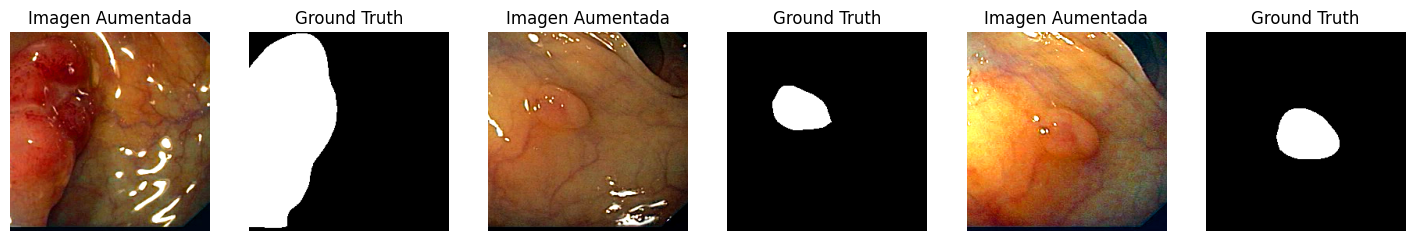

In [17]:
a=18
fig, ax = plt.subplots(1, 6, figsize=(a, a))

for i, (image, mask) in enumerate(train_dataset.take(3)):
    # numpy.
    image = image.numpy()
    mask = mask.numpy()

    # visualization
    ax[i*2].imshow(image[0])
    ax[i*2].axis('off')
    ax[i*2].set_title('Imagen Aumentada')

    # Mask and ground truth
    ax[i*2+1].imshow(mask[0], cmap='gray')
    ax[i*2+1].axis('off')
    ax[i*2+1].set_title('Ground Truth')

### 4. Carga de Modelos

En el desarrollo de modelos de segmentación, se utilizan diferentes estructuras pre-entrenadas conocidas como *backbones*. Algunos ejemplos son el EfficientNetB7, el SeresNet101 y el DenseNet169. Estas estructuras proporcionan una base sólida para los modelos de segmentación, permitiendo obtener resultados más precisos y eficientes.

Se toman los mejores modelos en combinacion de arquitectura+backbone+funcion de perdida.

In [18]:
#Deterministis models linknet
model_linknet_det= sm.Linknet('efficientnetb7', classes=1, activation='sigmoid')
model_linknet_det.load_weights("./checkpoint-LINKNET.h5")

#Deterministis models unet
model_unet_det = sm.Unet('efficientnetb7', classes=1, activation='sigmoid')
model_unet_det.load_weights("./checkpoint-UNET.h5")

258434480/258434480 [==============================] - 1s 0us/step


### Predictions

In [19]:
test=[(7, 1), (7, 2), (6, 3), (5, 5)]
valid=[(1, 0)]
train=[(1, 1)]

In [20]:
dataset_seleccionado_test=imagenes_seleccionadas(test,test_dataset)
dataset_seleccionado_valid=imagenes_seleccionadas(valid,valid_dataset)
dataset_seleccionado_train=imagenes_seleccionadas(train,train_dataset)

# Select some predictions

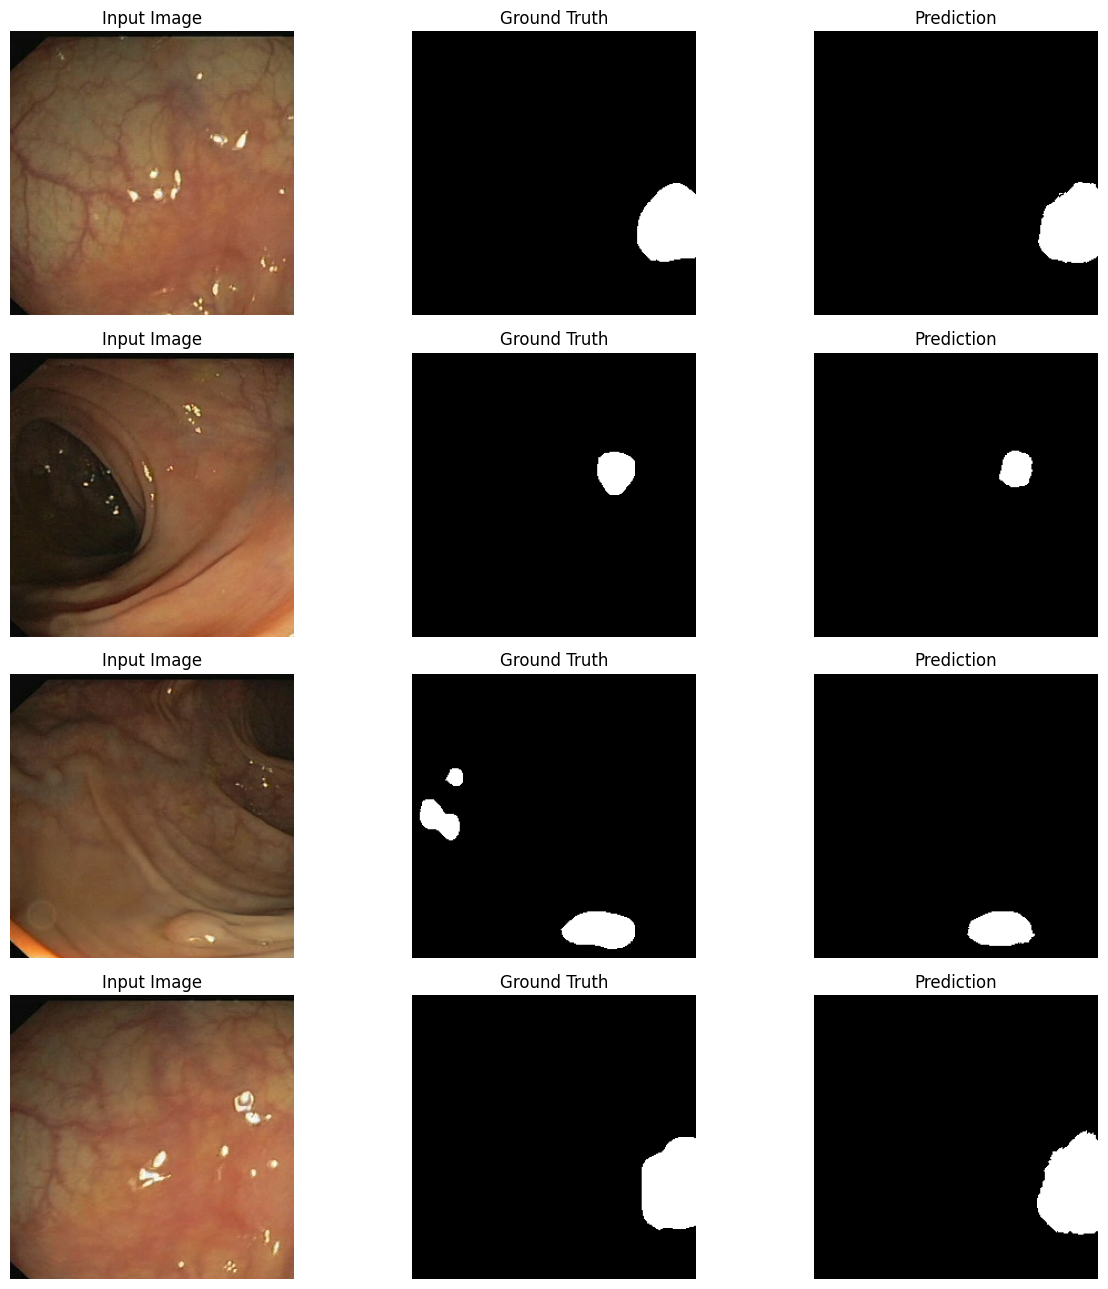

In [21]:
imagenes(1,model_linknet_det,test_dataset=dataset_seleccionado_test,n=4,unica=1)

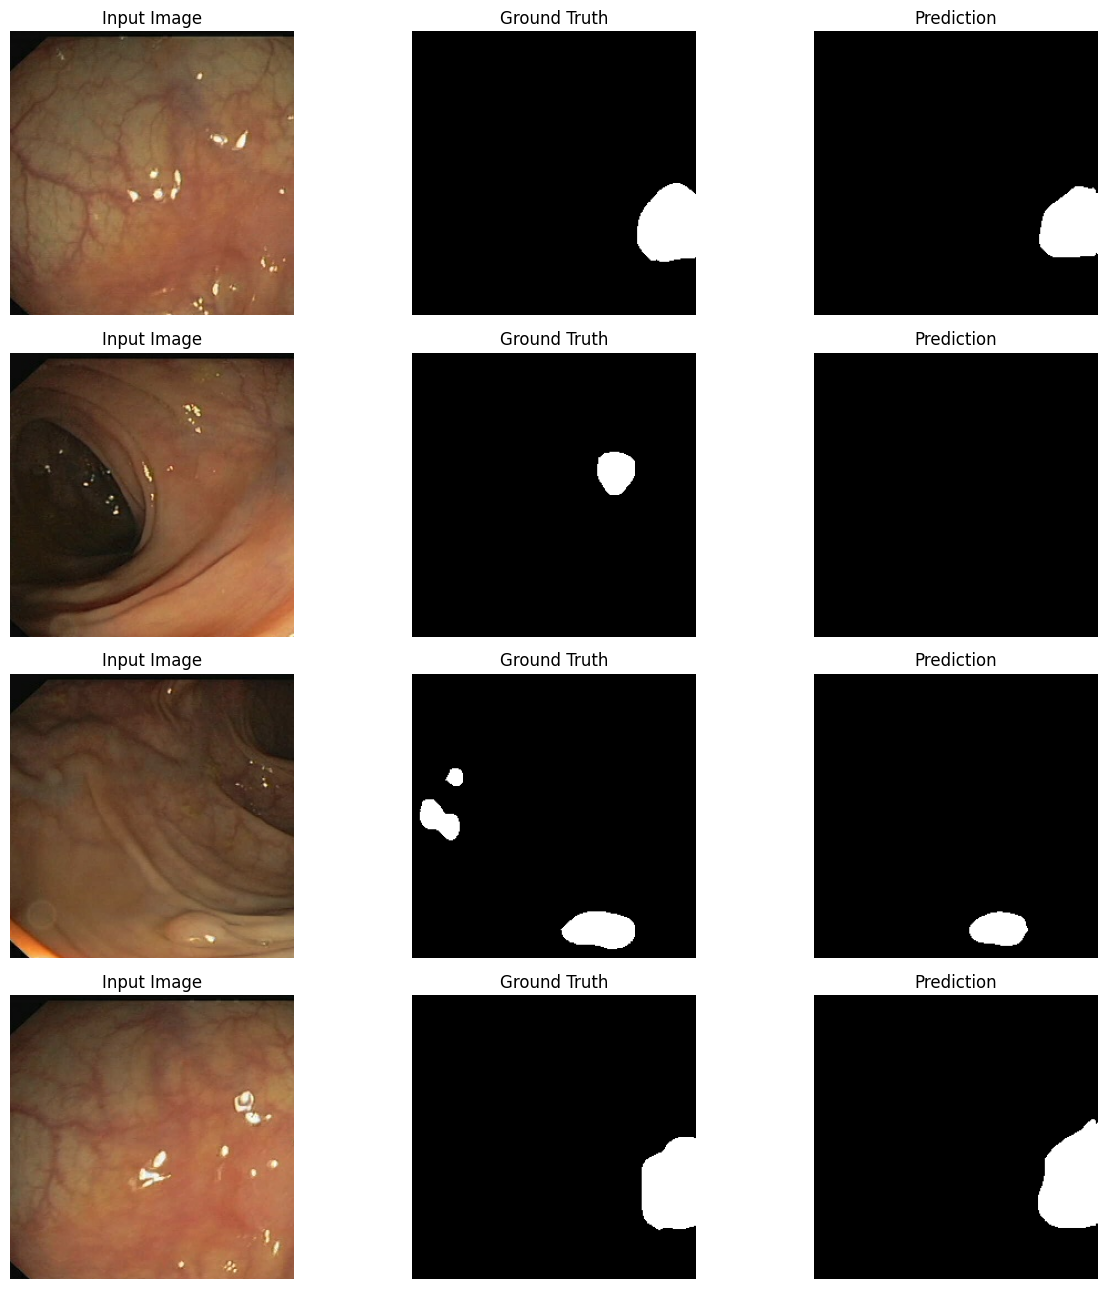

In [22]:
imagenes(1,model_unet_det,test_dataset=dataset_seleccionado_test,n=4,unica=1)